In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plt.style.use('bmh')

plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
data = pd.read_csv('Prepared Datasets/Mar2019Aug2019rs1h.csv')
data.datetime = pd.to_datetime(data.datetime)
data.set_index('datetime', inplace=True)

In [4]:
data['jump_mag_ext1']= data.apperture_ext1.diff().apply(lambda x: x if abs(x) > 2*data.aprtr_change_ext1.std() else np.nan).dropna()
data['jump_mag_ext2'] = data.apperture_ext2.diff().apply(lambda x: x if abs(x) > 2*data.apperture_ext2.diff().std() else np.nan).dropna()

data['is_jump_ext1'] = np.abs(data['jump_mag_ext1']) > 0
data['is_jump_ext2'] = np.abs(data['jump_mag_ext2']) > 0

<h1>Dataset Preparation for ML training</h1>

The dataset needs to be prepared accordingly for NN training. Here we are defining a number of windows (in hours because we are using hourly data) upon which we will be reshaping the datasets
We will be taking a sequence of n elements (n number of windows) that lead to an observation (jump or no jump)
For example if we have a window of 4, we will be taking x at indices 0,1,2,3 and y at 3
That way we are constructing many datasets for many windows and evaluating performance of the algorithm for each window. The best performing algorithm for each window hopefully provides insight

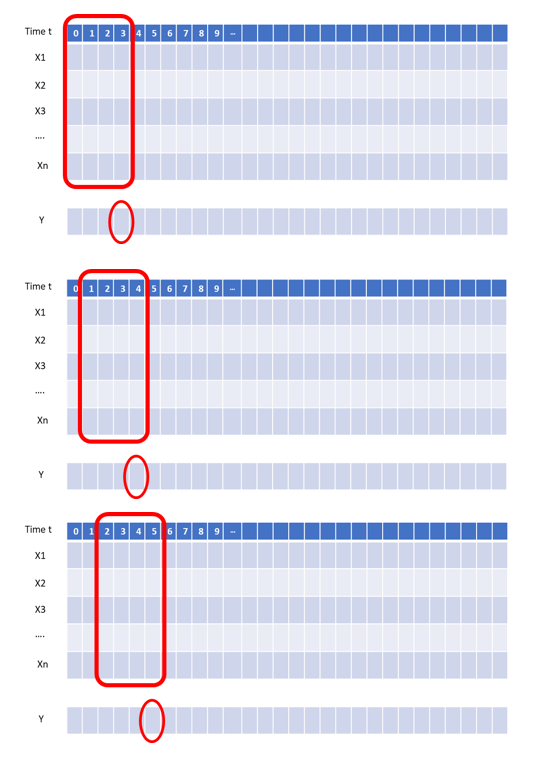

In [5]:
class Dataset_Preparator:
    
    def __init__(self):
        pass
    
    
    def chop_timeseries(self, data, window_size, X_labels, Y_labels):
        """Chop time series data in small sub-series of 'window_size' time steps
        
        data: The Dataframe containing time-series data in chronological order, to be chopped
        window_size: number of time steps to include in each chopped window of the base time series
        X_labels: The column labels of 'data' of  the independent variables
        Y_labels: The column labels of 'data' of the dependent variable
        """
        ml_dataset_x = data.loc[:, x_labels]
        ml_dataset_y = data.loc[:, y_labels]
        
        prepared_sets = {}
        
        X = []
        Y = []

        for i in range((len(ml_dataset_x) - w + 1)):
            X.append(ml_dataset_x.iloc[i:i+w].values)
            Y.append(int(ml_dataset_y.iloc[i+w-1].values))

        return (np.array(X), np.array(Y))


In [6]:
dt_prep = Dataset_Preparator()

windows = [1,2,3,4,6,8,10,12,18,24,36,48,72]
x_labels = ['air_temp_ib_facade', 'air_temp_ext2']
y_labels = ['is_jump_ext2']

prepared_sets = {}

for w in windows: 
    prepared_sets[w] = dt_prep.chop_timeseries(data, w, x_labels, y_labels)  
                                


In [7]:
class Model:
    
    def __init__(self, name=None, details=None):
        
        self.name = name
        self.details = details



    

<h1>Algorithm 1: Feedforward ANN</h1>

In [8]:
def define_ann_model(window, n_classes, hidden_neurons):
    n_inputs = window*n_classes
    
    model = Sequential(
        [
            Dense(hidden_neurons, activation='relu', input_shape=(n_inputs,)),
            Dense(1, activation='sigmoid')
        ]
    )
    
    return model

def preprocess_for_training(window):
    
    x = prepared_sets[window][0]
    y = prepared_sets[window][1]

    print(x.shape)
    x_len = x.shape[0]
    x_windows = x.shape[1]
    x_classes = x.shape[2]
    x = x.reshape(x_len, x_windows*x_classes)
    
    return x, y

In [9]:
window = 12

x, y = preprocess_for_training(window)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, shuffle=True, random_state=1)

pos_ratio = y.sum() / len(y)
print(f'Positives on entire dataset: {y.sum()}')
print(f'Positives on train dataset: {y_train.sum()}')
print(f'Positives on test dataset: {y_test.sum()}')
print(f'Positive ratio: {pos_ratio:.4f}')

pos_weight = (len(y_train) - y_train.sum())/y_train.sum()
int(pos_weight)

(2945, 12, 2)
Positives on entire dataset: 68
Positives on train dataset: 55
Positives on test dataset: 13
Positive ratio: 0.0231


41

In [10]:
test_ann = define_ann_model(window=window, n_classes=2, hidden_neurons=20)
test_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = test_ann.fit(x_train,y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0, class_weight={1:pos_weight, 0:1})

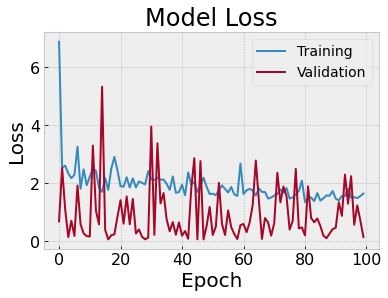

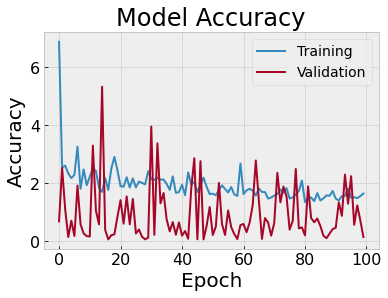

In [11]:
loss_fig = plt.figure()
ax = loss_fig.gca()
ax.plot(history.history['loss'], label='Training')
ax.plot(history.history['val_loss'], label = 'Validation')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

acc_fig = plt.figure()
ax = acc_fig.gca()
ax.plot(history.history['loss'], label='Training')
ax.plot(history.history['val_loss'], label = 'Validation')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

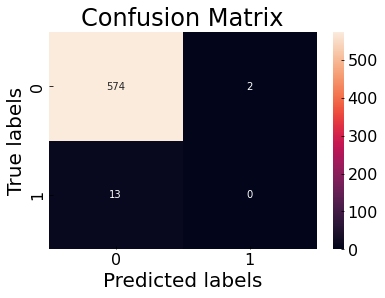

In [12]:
y_pred = test_ann.predict(x_test)

y_pred = (y_pred>0.5).flatten()
cm = confusion_matrix(y_test, y_pred)


fig=plt.figure(figsize=(6,4))
ax=fig.gca()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']);
ax.yaxis.set_ticklabels(['0', '1']);


In [13]:
##True Negative
TN=cm[0,0]
##False Negative
FN=cm[1,0]
##False Positives
FP=cm[0,1]
##True Positives
TP=cm[1,1]

sensitivity = TP/(TP+FN)
specificity = TN/(TN+TP)
precision = TP/(TP+FP)
fpr = FP / (FP+TN) # False Positive rate